# Code Optimization

**Author:** Nico Curti

**Course:** Software and Computing for Applied Physics - 87948

**Github:** [Nico-Curti](https://github.com/Nico-Curti)

How to obtain the best performances from your code:

1. Floating point computation
2. Vectorization
3. Structures

## 1st Rule

#### The math that you know does not exist in a computer

In [1]:
assert 0.1 + 0.1 == 0.2

In [2]:
assert 0.1 + 0.1 + 0.1 == 0.3

AssertionError: 

In [3]:
# writing 0.1 with 32 significant digits
print("{:f} = {:.32f}".format(0.1, 0.1)) 
print("{:.17f} + {:.17f} = {:.17f}".format(0.1, 0.2, 0.1 + 0.2))

# python hides the horrible truth from you
print(0.1)

0.100000 = 0.10000000000000000555111512312578
0.10000000000000001 + 0.20000000000000001 = 0.30000000000000004
0.1


therefore:

$$0.1 + 0.1 + 0.1 - 0.3$$
    
returns

$$5.5\ldots \cdot 10^{-17}$$
    
instead of 0

#### Some rules to keep in mind

* as soon as you start working on a computer, you have to forget about the idea of **continuous**

* any number that a computer can manipulate and output is, by necessity, with **finite precision**, and only an approximation of a **real number** (as in, a member of the real group)

To represent the number we divide it in 3 components:

* a field called **S**ignificant **S**
* a field called **e**xponent **e**
* a bit for the sign

so the number will represent the following:

$n = (-1)^s \cdot S \cdot 2^e$

Python works with 53 bit of precision, so the values that is working with internally are not the same as the ones that it shows using a simple print

> If Python were to print the true decimal value of the binary 
> approximation stored for 0.1, it would 
> have to display 
> **0.1000000000000000055511151231257827021181583404541015625**
> that is more digits than most people find useful.
> 
> -- [Python documentation on the floating points](https://python.readthedocs.io/fr/latest/tutorial/floatingpoint.html)

## Floating point arithmetics

Due to their structure, floating point arithmetics is not equivalent to the one you are familiar with using the real numbers

* associativity(+) : $(x+y)+z \neq x + (y+z)$
* associativity($\times$) : $(x \times y) \times z \neq x \times (y \times z)$
* distributivity : $x \times (y+z) \neq (x \times y)+(x \times z)$

* round : $x + \epsilon - x \neq \epsilon$
* division : $a/b \neq a \times (1/b)$
* algorithms : $(a+b) \times (a-b) \neq a^2-b^2$
* ecc.

In [4]:
a = 0.1
b = 0.2
c = 0.3
print((a + b) + c, a + (b + c))
# verify the associative property (+) including all bits
assert((a + b) + c == a + (b + c))

0.6000000000000001 0.6


AssertionError: 

Exact fractions, on the other end, are all the fractions that can be expressed as $1/2^N$:

* 0.5
* 0.25
* 0.125
* ...

for an extensive explaination, read [What Every Computer Scientist Should Know About Floating-Point Arithmetic](https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html)

if you have to test is two floating point numbers are **close enough** to be for all intent and purposes considered equal, you can use the function `math.isclose`:

```python
>>> import math
>>> a = 5.0
>>> b = 4.99998
>>> math.isclose(a, b, abs_tol=0.00003)
True
>>> math.isclose(a, b, abs_tol=0.00001)
False
>>> math.isclose(a, b, rel_tol=1e-5)
True
>>> math.isclose(a, b, rel_tol=1e-6)
False
```

If you don't care about numerical performances, you can also use the builtins modules **decimal** and **fraction**

```python
>>> from decimal import getcontext, Decimal
>>> getcontext().prec = 6
>>> Decimal(1) / Decimal(7)
Decimal('0.142857')
>>> getcontext().prec = 28
>>> Decimal(1) / Decimal(7)
Decimal('0.1428571428571428571428571429')
```

```python
>>> from fractions import Fraction
>>> Fraction(16, -10)
Fraction(-8, 5)
>>> Fraction('-3/7')
Fraction(-3, 7)
>>> Fraction('1.414213')
Fraction(1414213, 1000000)
>>> Fraction('7e-6')
Fraction(7, 1000000)
```

## Floating point exceptions

alongside precision errors and round offs, there are several possible exceptions that can be raised while operating with floating point numbers.

They are defined by the IEEE standard

* **Underflow** : the result of an operation is too small to be represented with a number

* **Overflow** : the result of an operation is too big to be represented with a number

* **Divide-by-zero** : when one tries to divide by 0

* **Invalid** : when the operation is not well defined (es. (0.0 / 0.0).

* **Inexact** : happens when the result of the operation is strongly approximated

## WTF Example

In [5]:
a = 250
b = 250
a == b

True

In [6]:
a is b

True

In [7]:
a = 300
b = 300
a == b

True

In [8]:
a is b

False

# Accuracy

## The algorithm matters!

Given the properties of the floating point numbers, different ways of performing your calculations can yield wildly different results!

Choosing the best algorithm is a craft, that needs to consider the floating point arithmetics, but also to balance it with the computational requirements in terms of memory and time!

## An example - the average

Lets suppose that we want to evaluate the average of a vector $x$.

we can estimate it using

$E[x] = \sum_{i=1}^N \frac{x_i}{N}$

or

$E[x] = \frac{1}{N}\sum_{i=1}^N x_i$

From a real number perspective these two versions are exactly equal, but for floating points they are not! 

In [9]:
N = 1000
mean_1 = 0.0
mean_2 = 0.0
for i in range(N):
    mean_1 += 0.1 / N
    mean_2 += 0.1
mean_2 /= N
print(f'Mean 1 = {mean_1:.32g}')
print(f'Mean 2 = {mean_2:.32g}')
print(f'Diff = {mean_2 - mean_1:.4g}')

Mean 1 = 0.10000000000000183741910575463407
Mean 2 = 0.099999999999998590016758726051194
Diff = -3.247e-15


For the estimate of the variance the results can be even more extremes:

in certain cases we can obtain a negative variance using the usual formula!

if you want to read more, check [Comparing three methods of computing standard deviation](https://www.johndcook.com/blog/2008/09/26/comparing-three-methods-of-computing-standard-deviation/)

### Algorithm Stability - Example

Keepin the summation (or average) as example, there are several solution to address the issue of the computational stability.

The most famous example is given by the Kahan summation scheme.

**Standard algorithm**

```python
sum = 0.0
for i in range(10):
    sum = sum + 0.1
print(sum)
>>> 0.9999999999999999
```

**Stable algorithm (KAHAN)**

```python
sum = 0.0
c = 0.0 # Variable to store the error
for i in range(10):
    y = 0.1 - c
    t = sum + y
    # Algebraically, c is always 0 when t is replaced by its value 
    # from the above expression.
    # But, when there is a loss, the higher-order y is cancelled out 
    # by subtracting y from c and all that remains is the lower-order 
    # error in c
    c = (t - sum) - y
    sum = t
print(t)
>>> 1.0
```

On the other end, sometimes a less precise algorithm can be preferred simply due to its **speed**.

On a traditional CPU different operations have wildly different execution times, and this could lead to dramatic differences in approach!

## Cost of Operations

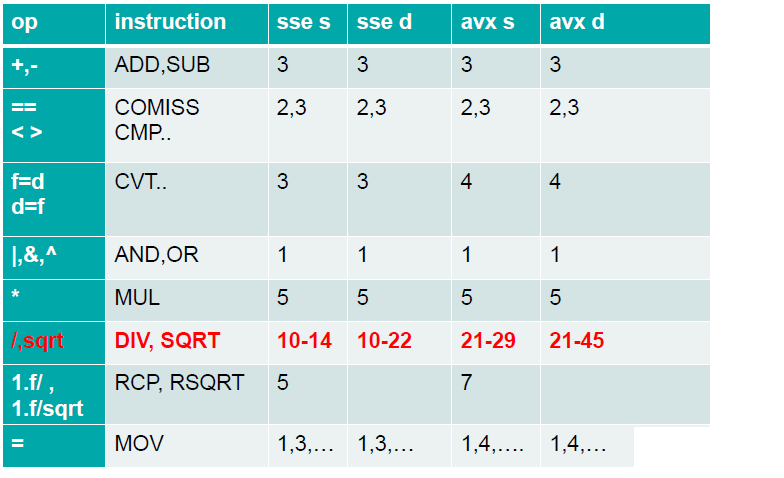

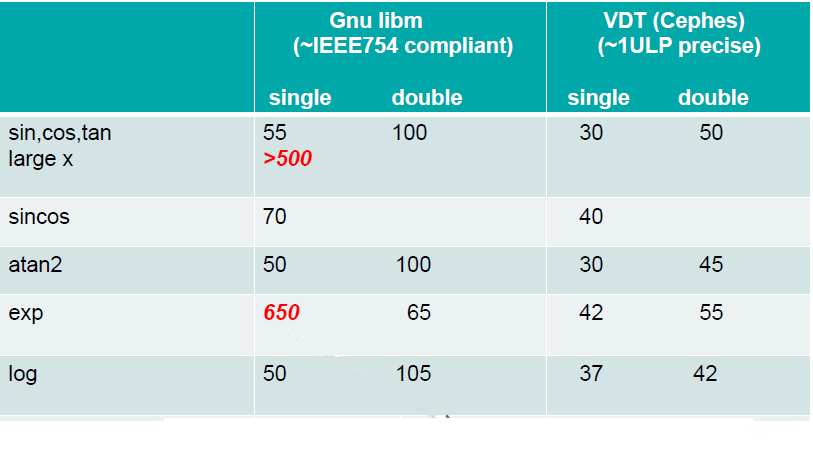

A consequence of this is that performing different operations that should be the same can have massive performance gain.
(an example with a spoiler)

In [10]:
import numpy as np

a = np.random.randn(100_000)

In [11]:
%timeit a/2

62.9 µs ± 599 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
%timeit a*0.5

56.5 µs ± 584 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


this can create some mind bending effect performance wise

In [13]:
%timeit a*1/2

119 µs ± 2.57 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [14]:
%timeit 1/2*a

52.2 µs ± 3.88 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


A classic example from computer science is the inverse of a square root of a number

$$ \frac{1}{\sqrt{x}} $$


you could use the standard formula, and obtain a reasonably good result:

In [15]:
from math import sqrt

print(1/sqrt(4))

0.5


## But

somebody (it is actually not known who) developed the following monster to do the same operation

In [16]:
def isqrt(number):
    import numpy as np
    assert number > 0
    threehalfs = 1.5
    x2 = number * 0.5
    y = np.float32(number) # converting the number to float32

    i = y.view(np.int32) #convert y to a int32 variable
    magic = np.int32(0x5f3759df) # magic number,  nobody knows why it works
    i = magic - np.int32(i >> 1) #difference bit-wise of the numbers
    y = i.view(np.float32)

    y = y * (threehalfs - (x2 * y * y))
    return float(y)

print(isqrt(4))

0.49915357479239103


This algorithm is less precise and more complicated, but it's so much faster than the naive implementation that is single handedly considered the code that allowed the birth of modern first person shooting games!

this is because this expression appears countless times in the dynamic light computation (to decrease it with distance), and this was fast and precise enough to allow to be used in real time

**NOTE**: this algorithm is actually performing the first step of a newton minimization algorithm 

If you are interested in some other "fast-math" operations, there is a longer set of examples on this topic in this [GIST](https://gist.github.com/Nico-Curti/3945d062644f458a5d39d5c16f77199b)

**NOTE:** Analogous implementation can be easily extended also to other programming languages.

# Speed

there are several ways to speed up and optimize an algorithm, and each one of them is appropriate to different situations:

* **code vectorization**
* memory access optimization
* code parallelization

The vectorization is the idea of expressing operations on entire data structures, and letting the CPU perform them on all the element at once.

the performance increase comes from a reduction of the cache I/O between CPU and RAM, a huge bottleneck in operations.

### Single Instruction Multiple Data

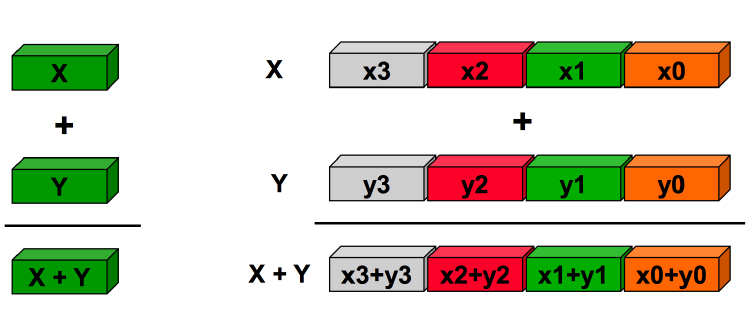

So we can use vectorization when:

* we have a loop over a data structure
* each step of the loop can be executed in parallel over the elements of the structure

vectorization is one of the easiest methods to implement and that have the best gain for effort... especially in high level programming languages

To implement vectorized code we need two main elements:

1. a data structure or any kind of container able to store multiple variables into sequential slots of memory
2. an operation which involves each element of the container independently

This approach is quite close to the idea behind functional programming (Map-Reduce schedule) and in many cases can be achieved using the same scheme.

# NumPy - Numerical Python

**Numpy** is the library that underpins all the python scientific ecosystem, for high performance computation and data analysis

The library provides an object, the **array** (*ndarray*, to be specific), that support vectorized and parallel computation, allowing high performance math in python, to a speed that can rival C (if properly implemented) 

The library also provides most common manipulation algorithms (later we'll discuss the extensions with **scipy**), all implemented in a vectorized fashion, but also read and write capabilities, tabular data manipulation, linear algebra, and even C++ code wrapping!

Good reference book (free online) are:

* [From Python to Numpy](https://www.labri.fr/perso/nrougier/from-python-to-numpy/)
* [Scipy Lecture Notes](https://scipy-lectures.org/)

In [17]:
import numpy as np
# vector 1x4
a = np.array([1, 2, 3, 4]) 
print(f'a = {a}')
# bidimensional array (matrix) 2x4
b = np.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
]) 
print(f'b = \n{b}')

a = [1 2 3 4]
b = 
[[1 2 3 4]
 [5 6 7 8]]


Every array has the following functions and methods available:

* array.shape : returns the dimensions of the array (a tuple of lenght alongside each dimension)
* array.dtype : returns the type of data inside the array (array are homogeneous)
* len(array) : return the size of the **rows** (the first dimension) of a multidimensional array (the dimensione over which you can loop over)
* np.array(list) o np.array(tuple) : convert them in a numpy array

In [18]:
a = [1, 2, 3, 4]
a_array = np.array(a)
b_array = np.asarray(list(a))
print(a_array.shape)
print(b_array.shape)
print(a_array.dtype)
print(len(a_array))

(4,)
(4,)
int32
4


it is also possible to specify the type of numbers that the array should contains.

**NOTE**: in a numpy array all the values **must** have the same type!

[https://docs.scipy.org/doc/numpy/user/basics.types.html](https://docs.scipy.org/doc/numpy/user/basics.types.html)

different data types can massively change the array size, and this could be a life saver when memory is limited!

(sadly there is no simple way of managing 1-bit arrays for booleans)

In [19]:
a = [1, 2, 3, 4]
print(np.array(a, dtype='uint8'))
print(np.array(a, dtype='float32'))
print(np.array(a, dtype='complex'))

[1 2 3 4]
[1. 2. 3. 4.]
[1.+0.j 2.+0.j 3.+0.j 4.+0.j]


In [20]:
a = np.array([1, 2, 3, 4], dtype='uint8')
print(a.size, a.itemsize, a.nbytes)

4 1 4


In [21]:
a = np.array([1, 2, 3, 4], dtype='float64')
print(a.size, a.itemsize, a.nbytes)

4 8 32


In [22]:
a = np.array([1, 2, 3, 4], dtype='complex')
print(a.size, a.itemsize, a.nbytes)

4 16 64


The *array* object makes the bases of all the programming languages and you don't need to reinvent them.

The possibility to store multiple variables into container can be found also in low level languages, even if some properties can be "hidden"...

# Vector - Standard Library

The **std :: vector** library is one of the most important for the C++ code and used in combination with other **std++11, std++14, std++17, std++20** libraries is very close to the Numpy one.

**Vector initialization**

```c++
#include <vector>
#include <algorithm>
#include <iterator>
#include <iostream>

int main () {
    std :: vector < int32_t > a {1, 2, 3, 4};
    std :: cout << "[";
    std :: copy(
        a.begin(),
        a.end() - 1,
        std :: ostream_iterator < int32_t >(std :: cout, ","));
    std :: cout << *(a.end() - 1);
    std :: cout << "]" << std :: endl;
    return 0;
}
```
```python
>>> [1,2,3,4]
```

**Vector Type, Size, Bitcount**

```c++
#include <vector>
#include <iostream>

int main () {
    std :: vector < int32_t > a {1, 2, 3, 4};
    std :: cout << a.size() << ", " 
                << typeid(a).name() << ", "
                << sizeof(a)
                << std :: endl;
    return 0;
}
```

```python
>>> 4, NSt3__26vectorIfNS_9allocatorIfEEEE, 12
```

## Create an Array

There are 3 important functions to create an array:

In [23]:
array_zeros = np.zeros(10) # vector of 1x10 zeros
print(f'array_zeros = {array_zeros}')

array_zeros = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [24]:
array_ones = np.ones(10) # vector of 1x10 ones
print(f'array_ones = {array_ones}')

array_ones = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [25]:
array_empty = np.empty(20) 
# vector 1x20 of null values (from the free memory used)
print(f'array_empty = {array_empty}')

array_empty = [1.37962185e-306 8.01097889e-307 4.45057637e-308 1.42419530e-306
 7.56603881e-307 1.11255866e-306 8.90098127e-307 7.56603881e-307
 1.78020848e-306 6.39754570e-308 1.60219035e-306 1.37961709e-306
 1.69109959e-306 1.69109959e-306 9.34603679e-307 1.37962049e-306
 4.45055939e-308 8.45603441e-307 2.22812926e-312 0.00000000e+000]


## Beware

**np.empty** does not contains zeros, but basically random numbers.

They are not properly random, but "garbage" remaining from the values of the previous of that section of memory

This is analogous to the standard library counter part of the C++ language

```c++
#include <vector>

const int32_t length = 10;
std :: vector < int32_t > array_zeros(length, 0);
std :: vector < float > array_ones(length, 1.f);
```

**or**

```c++
#include <vector>
#include <algorithm>

const int32_t length = 10;
std :: vector < int32_t > a(length);
std :: fill_n (a.begin(), length, 2);
```

**NOTE:** The default initialization of the C++ is always random, if not explicitly specified.
So you can think about the default C++ as a "np.empty" counter part.

## WTF Example

In [26]:
def energy_send(x):
    # Initializing a numpy array
    np.array([float(x)])

In [27]:
def energy_receive():
    # Return an empty numpy array
    energy = np.empty((), dtype=float)
    return energy

In [28]:
energy_send(123.456)
print(energy_receive())

123.456


## Operations between arrays and scalars

Numpy's array are not only simplifying the generation and management of data, but they have a huge number of operations that are already vectorized, such as **array-array** operations and **array-scalar**

In [29]:
a = np.array([1, 2, 3, 4])
b = np.array([2, 3, 4, 5])
print ('ARITHMETIC OPERATIONS')
print ('a = ', a)
print ('b = ', b)
print ('a * 10 : ', a * 10)
print ('a + 2 : ', a + 2)
print ('a^2 : ', a**2)

ARITHMETIC OPERATIONS
a =  [1 2 3 4]
b =  [2 3 4 5]
a * 10 :  [10 20 30 40]
a + 2 :  [3 4 5 6]
a^2 :  [ 1  4  9 16]


In [30]:
print ('OPERATIONS BETWEEN ARRAYS')
print ('a * b : ', a*b)
print ('a ** b : ', a**b)
print ('a + b : ', a+b)
print ('a - b : ', a-b)
print ('1 / a : ', 1/a) # gives floats!
print ('1 / a : ', 1//a)

OPERATIONS BETWEEN ARRAYS
a * b :  [ 2  6 12 20]
a ** b :  [   1    8   81 1024]
a + b :  [3 5 7 9]
a - b :  [-1 -1 -1 -1]
1 / a :  [1.         0.5        0.33333333 0.25      ]
1 / a :  [1 0 0 0]


In these cases all the *magic* behind code vectorization is hidden in the Python library, which aims to generate the most efficient execution according to the data structure.

### A By-Hand code vectorization

In [48]:
def standard_sum (a, b):
    assert len(a) == len(b)
    s = np.empty_like(a)
    for i in range(len(a)):
        s[i] = a[i] + b[i]
    return s

def vectorized_sum (a, b, step=1):
    assert len(a) == len(b)
    s = np.empty_like(a)
    for start in range(0, len(a), step):
        for j in range(start, start + step):
            s[j] = a[j] + b[j]
    return s

a = np.arange(0, 800)
b = np.arange(800, 1600)
np.testing.assert_allclose(standard_sum(a, b), vectorized_sum(a, b, step=2))

In [49]:
%timeit standard_sum(a, b)

163 µs ± 2.58 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [50]:
%timeit vectorized_sum(a, b, step=4)

200 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [53]:
%timeit vectorized_sum(a, b, step=5)

189 µs ± 722 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [54]:
%timeit vectorized_sum(a, b, step=32)

166 µs ± 1.88 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


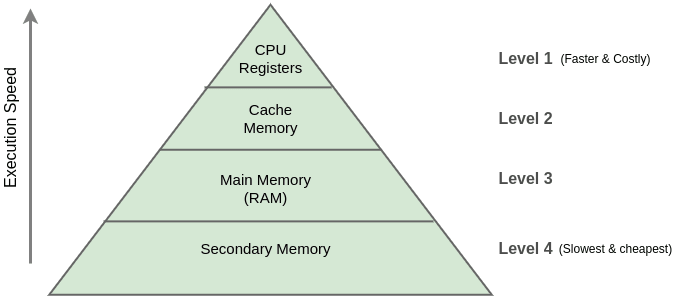

## Going back to the example of the averages

let's see how much faster the numpy array can get

Numpy provides an already optimized version of the mean (as with a lot of other functions)

    np.mean(array)

In [55]:
from time import time as now

tic = now() # start the clock
N = int(1e7)
x = np.random.rand(N)
mean_for_1, mean_for_2 = 0.0, 0.0

for x_i in x:
    mean_for_1 += x_i/N
    mean_for_2 += x_i
mean_for_2 /= N
toc = now()
print (f'Mean 1 = {mean_for_1:.32f}')
print (f'Mean 2 = {mean_for_2:.32f}')
print (f'Calculated in {toc - tic:.2g} sec')

tic = now()
mean_vec = np.mean(x)
toc = now()
print (f'Mean from numpy = {mean_vec:.32f}')
print (f'Calculated in {toc - tic:.2g} sec')

Mean 1 = 0.50013077980745335171519627692760
Mean 2 = 0.50013077980743791961515398725169
Calculated in 2.6 sec
Mean from numpy = 0.50013077980744380379718450058135
Calculated in 0.014 sec


## When and Where code vectorization

The code vectorization is a very powerful tool to speedup your code and in many cases is already implemented in the most common libraries.

So the best advice is to check if some operations are already implemented **or** can be easily implemented combining ready-to-use operations.

This could **NOT** be true if we talk about modern C++ (the classical low-level language!) standard libraries!

```c++
#include <vector>
#include <chrono>
#include <algorithm>
#include <iostream>

int main () {
    const int32_t length = 10000;
    std :: vector < float > a(length, 0.1f);
    std :: vector < float > b(length, 0.2f);
    std :: vector < float > s(length);

    std :: chrono :: steady_clock :: time_point tic = std :: chrono :: steady_clock :: now();

    std :: transform(a.begin(), a.end(), b.begin(), s.begin(), std :: plus < >{});

    std :: chrono :: steady_clock :: time_point toc = std :: chrono :: steady_clock :: now();
    std :: cout << std :: chrono :: duration_cast < std :: chrono :: microseconds >(toc - tic).count() << "[µs]" << std :: endl;
    return 0;
}
```

```bash
>>> 840 [µs]
```


```c++
#include <vector>
#include <chrono>
#include <iostream>

int main () {
    const int32_t length = 10000;
    std :: vector < float > a(length, 0.1f);
    std :: vector < float > b(length, 0.2f);
    std :: vector < float > s(length);

    std :: chrono :: steady_clock :: time_point tic = std :: chrono :: steady_clock :: now();

    for (int32_t i = 0; i < length; ++i)
        s[i] = a[i] + b[i];

    std :: chrono :: steady_clock :: time_point toc = std :: chrono :: steady_clock :: now();
    std :: cout << std :: chrono :: duration_cast < std :: chrono :: microseconds >(toc - tic).count() << "[µs]" << std :: endl;
    return 0;
}
```

```bash
>>> 340 [µs]
```

We have seen code vectorization using standard variable containers, but what happens with custom containers?

An example of custom container is an object class, defined to store multiple items together.

## Structured array

Numpy provides functionalities for managing tabular records of data, with the [**structured array**](https://docs.scipy.org/doc/numpy/user/basics.rec.html) data (and the more specialized **record array**).

It allows to store arbitrary tuples are items inside an array (including sub-structures or arrays)

This could be useful in some cases, but in general it would be better to use the library **pandas**.

In [66]:
data = [
    ('Rex', 9, 81.0),
    ('Fido', 3, 27.0),
]
mydtype = [
    ('name', 'U10'), # a string
    ('age', 'i4'), # an integer
    ('weight', 'f4'), # a float
]
x = np.array(data, dtype=mydtype)
print(x)
print(x['name'])
print(x['name'][0], x[0]['name'])

[('Rex', 9, 81.) ('Fido', 3, 27.)]
['Rex' 'Fido']
Rex Rex


### The two schools of thought

When we write a code we need to balance the *readability* of our script with the *performances* that we want/need to achieve.

In the majority of the cases the readability wins this challenge, but it does not mean that we are forced to write unefficient codes!

The object programming relies on the possibility to define very simple and understandable types, building more complex structures simply combining together naive structures.

Example: 

point object $\rightarrow$ geometrical shape $\rightarrow$ 3D structure $\rightarrow$ high level geometry

This approach could be summarized with the term

#### Structure of Arrays (SOA)

against the less intuitive and generalizable

#### Array of Structures (AOS)

## Structure of Arrays

In [68]:
class Point:
    def __init__ (self, x : float, y : float):
        self.x = x
        self.y = y
        
class Segment:
    def __init__ (self, src : Point, dst : Point):
        self.src = src
        self.dst = dst
        
class Line:
    def __init__ (self, pts : list):
        assert all(isinstance(pt, Point) for pt in pts)
        self.points = pts        

The most famous libraries are built with this criteria

For example [OpenCV](https://opencv.org/), one of the most useful library for image processing

In [80]:
class AoS_Point:
    def __init__ (self, x : float, y : float, z : float):
        self.x, self.y, self.z = x, y, z
        
N = 1000000
random_points = [AoS_Point(*np.random.randn(3)) for i in range(N)]

tic = now()
distances = np.empty(shape=N)
for i in range(0, N):
    x = random_points[i].x
    y = random_points[i].y
    z = random_points[i].z
    d = np.sqrt(x**2 + y**2 + z**2)
    distances[i] = d

toc = now()
print(f'Elapsed Time: {toc - tic:.4g} sec')

Elapsed Time: 1.37 sec


The opposite approach is given by re-thinking the structure of the objects according to the computation that we need to perform.

In this way we can **optimize** the accesses to the memory, forcing the object to have a contiguous memory locations!

In [81]:
class SoA_Point:
    def __init__ (self, x : list, y : list, z : list):
        self.x, self.y, self.z = x, y, z
        
N = 1000000
random_points = SoA_Point(x=np.random.randn(N), 
                          y=np.random.randn(N), 
                          z=np.random.randn(N))

tic = now()
distances = np.empty(shape=N)
for i in range(0, N):
    x = random_points.x[i]
    y = random_points.y[i]
    z = random_points.z[i]
    d = np.sqrt(x**2 + y**2 + z**2)
    distances[i] = d

toc = now()
print(f'Elapsed Time: {toc - tic:.4g} sec')

Elapsed Time: 1.553 sec


## Why is it slower?!?!

There are several aspects to take in mind when we want to optimize a code:

1. The variable types could be homogeneous or not
2. There could be sequential accesses to the memory or not
3. There are optimizations hidden in our interpreter
4. etc..

**“Premature optimization is the root of all evil”** (cit. Donald Knuth)

```c++
#include <vector>
#include <chrono>
#include <algorithm>
#include <iostream>
#define N 1000

struct AoS_Point {
    float x = 3.14f;
    int y = 3;
    double z = 3.14;
};

int main () {
    std :: vector < AoS_Point > pts(N);
    std :: vector < float > res(N);
    std :: chrono :: high_resolution_clock :: time_point tic = std :: chrono :: high_resolution_clock :: now();
    for (int i = 0; i < N; ++i) {
        for (int j = 0; j < N; ++j) {
            float x = pts[j].x;
            float y = pts[j].y;
            float z = pts[j].z;
            float d = std :: sqrt(x * x + y * y + z * z);
            res[j] = d;
        }    
    }
    std :: chrono :: high_resolution_clock :: time_point toc = std :: chrono :: high_resolution_clock :: now();
    std :: cout << std :: chrono :: duration_cast < std :: chrono :: microseconds >(toc - tic).count() << " micro sec" << std :: endl;
    return 0;
}
```

```python
>>> 43760 micro sec
```

```c++
#include <vector>
#include <chrono>
#include <algorithm>
#include <iostream>
#define N 1000

struct SoA_Point {
    std :: vector < float > x {N, 3.14f};
    std :: vector < int > y {N, 3};
    std :: vector < double > z {N, 3.14};
};

int main () {
    SoA_Point soa;
    std :: vector < float > res(N);
    std :: chrono :: high_resolution_clock :: time_point tic = std :: chrono :: high_resolution_clock :: now();
    for (int i = 0; i < N; ++i) {
        for (int j = 0; j < N; ++j) {
            float x = soa.x[j];
            float y = soa.y[j];
            float z = soa.z[j];
            float d = std :: sqrt(x * x + y * y + z * z);
            res[j] = d;
        }    
    }
    std :: chrono :: high_resolution_clock :: time_point toc = std :: chrono :: high_resolution_clock :: now();
    std :: cout << std :: chrono :: duration_cast < std :: chrono :: microseconds >(toc - tic).count() << " micro sec" << std :: endl;
    return 0;
}
```

```python
>>> 34420 micro sec
```

## Let's try to optimize a code together

Since we want to understand the finer details of optimization, we will check out a snippet of the low-level programming language, aka C++.

Let's see the "initial.cpp" code in the project folder.

#### Default command line

```bash
$ make initial
/usr/bin/g++-10 -std=c++11 initial.cpp -o initial
./initial

# Number of particles        : 1024
# Number of simulations      : 100
# Total Time (s)             : 4.64
# Average Time per iteration : 0.0464
```

#### Optimized command line

```bash
$ make optimized
/usr/bin/g++-10 -std=c++11 -O3 initial.cpp -o initial_optimized
./initial_optimized

# Number of particles        : 1024
# Number of simulations      : 100
# Total Time (s)             : 0.804
# Average Time per iteration : 0.00804
```

Speed Up: $\sim$6x

#### Optimized command line

```bash
$ make vectorized
/usr/bin/g++-10 -std=c++11 -Ofast -mavx vect.cpp -o vectorized
./vectorized

# Number of particles        : 1024
# Number of simulations      : 100
# Total Time (s)             : 0.304
# Average Time per iteration : 0.00304
```

Speed Up: $\sim$3x

#### SoA refactory

```bash
$ make soa
/usr/bin/g++-10 -std=c++11 -Ofast -mavx soa.cpp -o soa
./soa

# Number of particles        : 1024
# Number of simulations      : 100
# Total Time (s)             : 0.402
# Average Time per iteration : 0.00402
```

Speed Up: $\sim$2x

A little spoiler:

> Have you ever check the command line of your Python interpreter?!

In [99]:
!python --help

usage: python [option] ... [-c cmd | -m mod | file | -] [arg] ...
Options and arguments (and corresponding environment variables):
-b     : issue warnings about str(bytes_instance), str(bytearray_instance)
         and comparing bytes/bytearray with str. (-bb: issue errors)
-B     : don't write .pyc files on import; also PYTHONDONTWRITEBYTECODE=x
-c cmd : program passed in as string (terminates option list)
-d     : turn on parser debugging output (for experts only, only works on
         debug builds); also PYTHONDEBUG=x
-E     : ignore PYTHON* environment variables (such as PYTHONPATH)
-h     : print this help message and exit (also --help)
-i     : inspect interactively after running script; forces a prompt even
         if stdin does not appear to be a terminal; also PYTHONINSPECT=x
-I     : isolate Python from the user's environment (implies -E and -s)
-m mod : run library module as a script (terminates option list)
-O     : remove assert and __debug__-dependent statements; add .o

# Hands On Exercise

### Metropolis - Hastings algorithm

> In statistics and statistical physics, the Metropolis–Hastings algorithm is a Markov chain Monte Carlo (MCMC) method for obtaining a sequence of random samples from a probability distribution from which direct sampling is difficult.
> A classical example of its application is the numerical evaluation of $\pi$ value.

#### Data

We have a squared domain in which play our pebble game

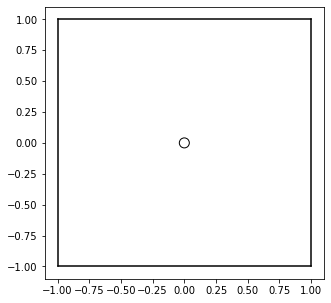

In [98]:
import pylab as plt
a = np.linspace(-1, 1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
_ = ax.plot(a, np.zeros_like(a) -1, 'k')
_ = ax.plot(np.zeros_like(a) -1, a, 'k')
_ = ax.plot(a, np.ones_like(a), 'k')
_ = ax.plot(np.ones_like(a), a, 'k')
_ = ax.scatter([0], [0], marker='o', facecolor='none', edgecolor='k', s=100)

Inside this domain we will "throw" numbers sampled from a uniform distribution in this domain.

For each extraction we will evaluate its distance from the center, according to these two criteria:

1. distance less (or equal) than 1 leads to a **valid** extraction and it will be accepted
2. distance greater than 1 leads to an **invalid** extraction and it will be rejected

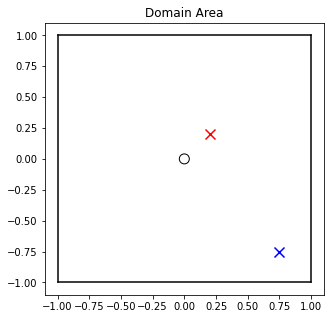

In [57]:
_ = ax.scatter([0.2], [0.2], marker='x', color='r', s=100)
_ = ax.scatter([0.75], [-0.75], marker='x', color='b', s=100)
fig

According to the Monte Carlo simulation scheme, if we will consider a lot of extraction we will be able to evaluate the integral of the circle with a sufficient precision and from the comparison with the total amount of extraction we will compute:

$$
A_{\mbox{square}} : N_{\mbox{trials}} = A_{\mbox{circle}} : N_{\mbox{hits}}
$$

where

$$
A_{\mbox{circle}} = r \times r \times \pi = \pi \quad \mbox{AND} \quad A_{\mbox{square}} = 4
$$

So, in conclusion

$$
\pi = 4 \times \frac{N_{\mbox{hits}}}{N_{\mbox{trials}}}
$$

## Are you ready to play???

**Worst Possible Python Code**

In [63]:
import numpy as np
from time import time as now

N = 10000
Nhits = 0.0
tic = now()
for i in range(N):
    x = np.random.rand() * 2 - 1
    y = np.random.rand() * 2 - 1
    distance = x*x + y*y
    if distance < 1:
        Nhits += 1.0
toc = now()
print(f'Value of PI: {4 * Nhits /N:4g}')
print(f'Elapsed time: {toc - tic:3f} sec')

Value of PI: 3.1356
Elapsed time: 0.010000 sec


The idea is valid...

... but a larger statistic could help the stability of the result!

We can re-iterate the same evaluation several times to get the average value as more stable result

In [65]:
N = 10000 # number of MC events
N_run = 1000 # number of runs
pi = np.zeros(N_run) # values of pi
tic = now()
for I in range(N_run):
    Nhits = 0.0
    for i in range(N):
        x = np.random.rand() * 2 - 1
        y = np.random.rand() * 2 - 1
        distance = x*x + y*y
        if distance < 1:
            Nhits += 1.0
    pi[I] = 4. * Nhits / N
        
toc = now()
print('pi with', N, 'steps for', N_run, 
      'runs is', np.mean(pi), 'in', toc-tic, 'sec'
     )

pi with 10000 steps for 1000 runs is 3.1409507999999997 in 8.405994415283203 sec


### How can it be optimized?

Now it is your turn...

One possible solution:

In [62]:
N = 10000 # number of MC events
N_run = 1000 # number of runs
tic = now() # start clock
pi = 4. * np.sum(
    np.where(
        (np.random.rand(N_run, N)*2 - 1)**2 + \
        (np.random.rand(N_run, N)*2 - 1)**2 < 1, 
        1, 
        0
    )
) / (N * N_run)
toc = now()
print('pi with', N, 'steps for', N_run, 
      'runs is', np.mean(pi), 'in', toc-tic, 'sec'
     )

pi with 10000 steps for 1000 runs is 3.141826 in 0.33299994468688965 sec


Another improvement:

In [61]:
N = 10000 # number of MC events
N_run = 1000 # number of runs
tic = now() # start clock
pi = np.mean(
    (
        np.sum(
            np.random.uniform(
                low=-1, 
                high=1, 
                size=(2, N_run, N)
            )**2, 
            axis=0
        ) < 1
    ), 
    axis=1
) * 4
toc = now()
print('pi with', N, 'steps for', N_run, 
      'runs is', np.mean(pi), 'in', toc-tic, 'sec'
     )

pi with 10000 steps for 1000 runs is 3.1417232000000004 in 0.24599099159240723 sec


## Can it be improved further?

**YES** ... but the next time